In [4]:
from scipy.signal import chirp, spectrogram
import matplotlib.pyplot as plt
import numpy as np

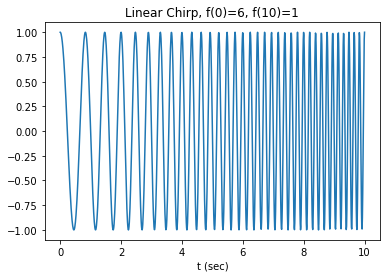

In [5]:
t = np.linspace(0, 10, 1000)
w = chirp(t, f0=1, f1=6, t1=10, method='linear')
plt.plot(t, w)
plt.title("Linear Chirp, f(0)=6, f(10)=1")
plt.xlabel('t (sec)')
plt.show()

In [7]:
from openrobot_vesc_pyserial import vesc_pyserial as vs
import serial
import threading

vesc_class = vs.VESC_USB(serial.Serial("/dev/ttyACM0", 115200, timeout=0.5), 0)

# receive thread
vesc_rx_thread = threading.Thread(target=vesc_class.readThread)
vesc_rx_thread.start()
print("VESC USB RX Thread Started", vesc_class)

VESC USB RX Thread Started <openrobot_vesc_pyserial.vesc_pyserial.VESC_USB object at 0x7f90743569a0>


In [8]:
def get_value():
    send_data = vs.packet_encoding(vs.COMM_PACKET_ID['COMM_GET_VALUES'])
    vesc_class.serial_write(send_data)

def out_duty(duty):
    comm_set_cmd = vs.COMM_PACKET_ID['COMM_SET_DUTY']
    send_data = vs.packet_encoding(comm_set_cmd, duty)
    vesc_class.serial_write(send_data)
    
def out_current(curr):
    comm_set_cmd = vs.COMM_PACKET_ID['COMM_SET_CURRENT']
    send_data = vs.packet_encoding(comm_set_cmd, curr)
    vesc_class.serial_write(send_data)

In [9]:
send_data = vs.packet_encoding(vs.COMM_PACKET_ID['COMM_GET_VALUES'])
send_data

[2, 1, 4, 64, 132, 3]

In [10]:
vesc_class.debug_print_get_value_return = False
get_value()
out_duty(0.3)
print(vesc_class.values.duty)

0


In [11]:
import time
import simpy
import simpy.rt
import csv
import pandas as pd

def current_milli_time():
    return round(time.time() * 1000)

def openloop_sine_duty_out(env):
    t_start = current_milli_time()/1000
    while True:
        print("sim_time:%.4fs"%(current_milli_time()/1000 - t_start), w[env.now])
        start = time.perf_counter()
        ####
        get_value()
        A = 4.0
        out_duty(A*w[env.now])
        print(vesc_class.values.duty)
        ####
        yield env.timeout(1)
        end = time.perf_counter()
        #print('Duration of one simulation time unit: %.4fs' % (end - start))
        
def openloop_sine_current_out(env):
    
    f = open('data.csv', 'w', encoding='utf-8', newline='')
    wr = csv.writer(f)
    wr.writerow(["index", "time", "curr_in", "curr_out"])
    
    #indexName = { "time" : [], "curr_in" : [], "curr_out": [] }
    #csv_pd = pd.DataFrame(columns = indexName)
    
    t_start = current_milli_time()/1000
    while True:
        #start = time.perf_counter()
        
        #### Loop ####
        A = 6.0
        current_input = A*w[env.now]
        out_current(current_input)
        
        get_value()
        current_output = vesc_class.values.motor_current
        #print("motor current, input:{:3f} / output:{:3f}".format(current_input, current_output))
        
        time = (current_milli_time()/1000 - t_start)
        #print("index:%d"%env.now, ", sim_time:%.3fsec"%time, ",sine_sweep:%.3f"%w[env.now])
        
        wr.writerow([env.now, time, current_input, current_output])
        #csv_pd.loc[env.now] = [time, current_input, current_output]
      
        if env.now == (len(w)-1):
            print('Total simulation time: %.3fs' % (current_milli_time()/1000 - t_start)) 
            f.close()
            #csv_pd.to_csv('data.csv')
        #### Loop ####
        
        yield env.timeout(1)
        #end = time.perf_counter()

In [12]:
env = simpy.rt.RealtimeEnvironment(factor=0.01)
proc = env.process(openloop_sine_current_out(env))
env.run(until=len(w))

Total simulation time: 9.989s


NameError: name 'curr_in' is not defined

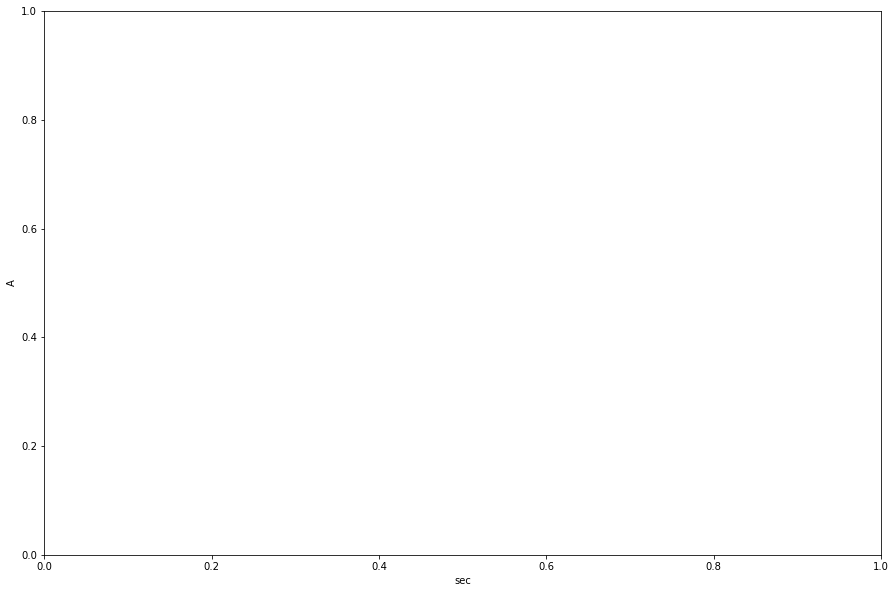

In [13]:
#df = pd.read_csv('data.csv')
#t = df['time'].to_list()
#curr_in = df['curr_in'].to_list()
#curr_out = df['curr_out'].to_list()

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.xlabel('sec') 
plt.ylabel('A') 
plt.plot(t, curr_in, label="current in")
plt.plot(t, curr_out, label="current out")
plt.legend()

In [14]:
asdfasdfasd

NameError: name 'asdfasdfasd' is not defined

In [ ]:
vesc_class.serial_name.close()
vesc_class.exitThread_usb = True
del vesc_class